### 라이브러리 호출

In [44]:
import re   #정규식
import random   #데이터 증강용 난수
import numpy as np   #행렬 연산
import pandas as pd   #데이터프레임
import tensorflow as tf   #신경망
import matplotlib.pyplot as plt   #데이터 시각화
from tqdm.notebook import tqdm   #학습 과정 출력


import gensim   #Word2Vec
from konlpy.tag import Mecab   #형태소 분석


from nltk.translate.bleu_score import sentence_bleu   #bleu 연산
from nltk.translate.bleu_score import SmoothingFunction   #bleu 연산

### 데이터셋 불러오기

In [45]:
dataset = pd.read_csv("ChatbotData1.csv")
dataset.drop(("label"), axis="columns", inplace=True)

display(dataset.sample(5))

,Q,A
3855,임신이면 어떡하지,축하할 일이죠.
3879,잊어야겠다고 마음 먹고 맨날맨날 놀고 있습니다,바쁜 게 도움이 되지요.
638,나만 일시켜서 짜증폭발,일 분배를 다시 요청해보세요.
5901,너 만든 사람은 누구야?,마음과 마음을 이어보고 싶어하는 사람이 만들었어요.
636,나만 이상한 사람이래,그 말을 한 사람이 가장 이상할 거예요.


### 레코드 수, 결측치, 중복 데이터 확인
 - 데이터 수는 총 11,823개이며, 0개의 결측치, 73개의 중복 데이터가 존재

In [46]:
dataset.info()
dup = dataset.duplicated()
dup = dup.value_counts()[True]

print(f"Dupliacted Data Num: {dup:,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB
Dupliacted Data Num: 73


### 3. 데이터 전처리

In [47]:
### 중복 데이터 제거(갯수:11,750)
dataset.drop_duplicates(inplace=True)
print(f"Data Num: {len(dataset):,}")

Data Num: 11,750


In [48]:
## 문장들 전처리
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [49]:
dataset["Q"] = dataset["Q"].apply(preprocess_sentence)
dataset["A"] = dataset["A"].apply(preprocess_sentence)

display(dataset.sample(5))

,Q,A
8925,걔한테 잘보이고 싶은데 무슨 옷을 입는게 좋을까 ?,깔끔한 스타일이 좋을 것 같습니다 .
8139,좋다가 밉다가 무한반복,감정의 롤러코스터를 타나봐요 .
1936,발레 배우려고,선이 예뻐질 거예요 .
10259,썸 탈 때 예민한 부분 말해 ?,알아가는 단계니 디테일한 건 말 안해도 돼요 .
6937,어떻게 맘정리를할까 ?,열심히 하루하루를 살아가다보면 정리가 될 거예요 .


#### okt를 이용한 형태소 기준 문장 분할

In [50]:
from konlpy.tag import Okt

o = Okt()

dataset["Q"] = dataset["Q"].apply(lambda x: " ".join(o.morphs(x)))
dataset["A"] = dataset["A"].apply(lambda x: " ".join(o.morphs(x)))

display(dataset.sample(5))

,Q,A
6734,술 을 마시니까 더 생각나는 날이에,기억 에 취해 서 그럴 거 예요 .
9845,사랑 경험 이 없어,지금 부터 해보면 돼요 .
3324,오늘 화장 떴어,각질 제거 를 해보세요 .
6859,아직도 너무 힙듭니 다 .,아무렇지도 않은 날 이 올 거 예요 .
32,가족 들 이랑 어디 가지 ?,온 가족 이 모두 마음 에 드는 곳 으로 가보세요 .


### 디코더 문장 < sos>, < EOS> 토큰 추가
    - 디코더에 입력할 데이터 문장 앞, 뒤에 <SOS>와 <EOS> 토큰을 추가해야함.

In [51]:
dataset["A"] = dataset["A"].apply(lambda x: "<sos> " + x + " <eos>")

display(dataset.sample(5))

,Q,A
1954,발표 할 때 자꾸 떨려,<sos> 발표 는 누구 나 떨려요 . <eos>
9709,말 이 안 예쁘게 나와,<sos> 말 하기 전 에 생각 하고 말 하는 습관 을 길러 보세요 . <eos>
7876,잘가,<sos> 안녕 . <eos>
8242,짜증나네 .,<sos> 심호흡 해보세요 . <eos>
1556,맛집 가고 싶어,<sos> 벌써 먹고 싶어요 . <eos>


## 데이터 토큰화
    -문장 길이 및 토큰 사용 빈도를 확인하기 위해, 토크나이저를 생성
    - 12,594개의 토큰을 획득

In [52]:
def get_tokenizer(corpus, vocab_size):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',
        oov_token="<UNK>",
        num_words=vocab_size
    )
    corpus_input = [sentence.split() for sentence in corpus]
    tokenizer.fit_on_texts(corpus_input)
    
    if vocab_size is not None:
        words_frequency = [w for w,c in tokenizer.word_index.items() if c >= vocab_size + 1]
        for w in words_frequency:
            del tokenizer.word_index[w]
            del tokenizer.word_counts[w]
    
    return tokenizer


concat = pd.concat([dataset["Q"], dataset["A"]])
tokenizer = get_tokenizer(concat, None)

print("Tokenizer Vocab Size:", f"{len(tokenizer.word_index):,}")

Tokenizer Vocab Size: 12,594


## 문장 인코딩
 - 생성한 토크나이저를 바탕으로 자연어 글자를 정수 형태로 변환

In [53]:
def encoding_sentence(copus, tokenizer):
    tensor = tokenizer.texts_to_sequences(copus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor, padding='post'
    )
    return tensor


enc_tensor = encoding_sentence(dataset["Q"], tokenizer)
dec_tensor = encoding_sentence(dataset["A"], tokenizer)

In [54]:
#데이터 빈도 시각화 함수=========================
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print("< Sentence Info >".center(100, "="))
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")
    print("=" * 100)
#End===========================================

#### 데이터 문장 길이 확인
    - 질문의 경우, 문장이 평균이 약 5개 토큰으로 이루어짐
    - 대답의 경우, 문장이 평균이 약 8개 토큰으로 이루어짐 

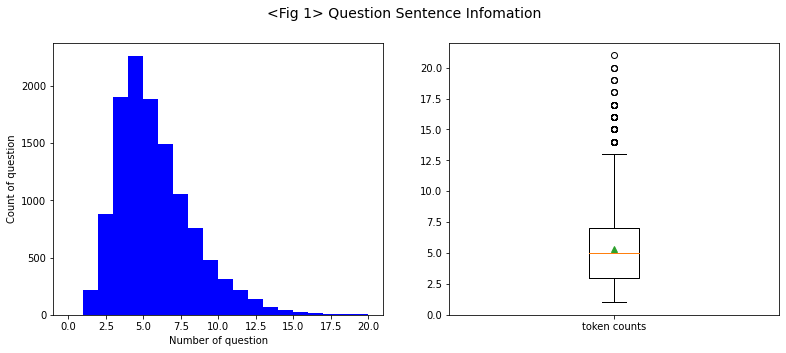

=========================================< Sentence Info >==========================================
길이 최대:      21
길이 최소:       1
길이 평균:      5.298
길이 표준편차:   2.561

 25/100분위:    3.000
 50/100분위:    5.000
 75/100분위:    7.000
 MAX/100분위:  13.000
 IQR:   4.000


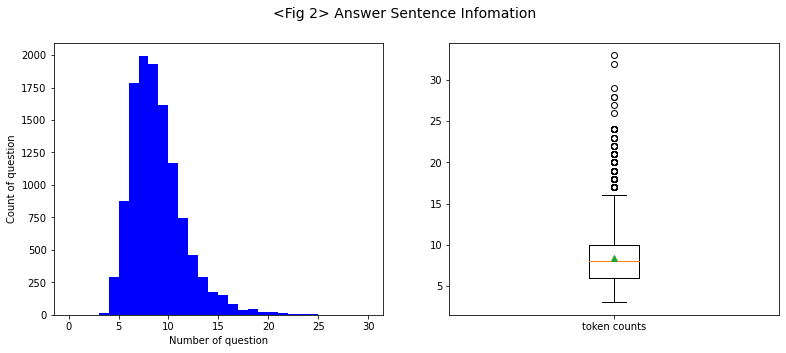

=========================================< Sentence Info >==========================================
길이 최대:      33
길이 최소:       3
길이 평균:      8.400
길이 표준편차:   2.762

 25/100분위:    6.000
 50/100분위:    8.000
 75/100분위:   10.000
 MAX/100분위:  16.000
 IQR:   4.000


In [55]:
def get_sentence_len(tensor):
    counts = []
    for sentence in tensor.tolist():
        try:
            idx = sentence.index(0)
            counts.append(idx)
        except:
            counts.append(len(sentence))
    return counts


enc_counts = get_sentence_len(enc_tensor)
dec_counts = get_sentence_len(dec_tensor)

show_sentence_length(enc_counts, "<Fig 1> Question Sentence Infomation", [0, 20])
show_sentence_length(dec_counts, "<Fig 2> Answer Sentence Infomation", [0, 30])

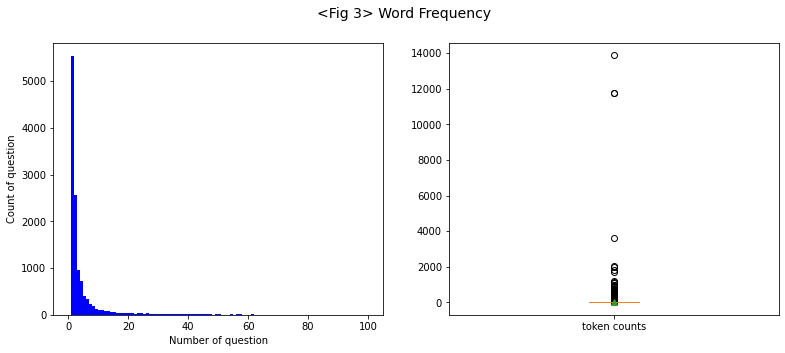

=========================================< Sentence Info >==========================================
길이 최대:    13870
길이 최소:       1
길이 평균:     12.781
길이 표준편차: 203.209

 25/100분위:    1.000
 50/100분위:    2.000
 75/100분위:    4.000
 MAX/100분위:   8.500
 IQR:   3.000


In [56]:
freq = [value for value in tokenizer.word_counts.values()]

show_sentence_length(freq, "<Fig 3> Word Frequency", [0, 100])

#### 사용빈도 4분위에 해당하는 토큰 개수 확인

    - 사용 빈도 4분위에 해당하는 토큰의 수는 총 11,621개 입니다.
    - 질문의 문장의 길이가 13이하이고 대답의 문장길이가 16이하인 문장만 추출

In [57]:
def wordNumByFreq(tokenizer, freq_num):
    sorted_freq = sorted(tokenizer.word_counts.items(), key=lambda x: x[1])
    for idx, (_, freq) in enumerate(sorted_freq):
        if freq > freq_num: break;
    return idx


print(f"Words Used Under {16}: {wordNumByFreq(tokenizer, 16):,}")

Words Used Under 16: 11,621


In [58]:
#토크나이저 생성===============
concat = pd.concat([dataset["Q"], dataset["A"]])
tokenizer = get_tokenizer(concat, 5872)
#End===========================


#문장 길이 정제================
q = dataset["Q"].apply(lambda x: len(tokenizer.texts_to_sequences([x])[0]) <= 14)
a = dataset["A"].apply(lambda x: len(tokenizer.texts_to_sequences([x])[0]) <= 17)
dataset = dataset[q & a]
#End===========================


print("Tokenizer Vocab Size:", f"{len(tokenizer.word_index):,}")


Tokenizer Vocab Size: 5,872


### 테스트 데이터 분할
    - 모델 검증 단계에서 사용할 100개의 테스트 데이터를 분할 합니다.


In [59]:
test_dataset = dataset[:100]
dataset = dataset[100:]

display(test_dataset.sample(5))

,Q,A
33,가족 들 이랑 여행 갈거야,<sos> 좋은 생각 이에요 . <eos>
98,걔 랑 같은 반 됐으면 좋겠다,<sos> 당신 의 운 을 믿어 보세요 . <eos>
14,가난한 자의 설움,<sos> 돈 은 다시 들어올 거 예요 . <eos>
56,감기 약 이 없어,<sos> 병원 가세 요 . <eos>
102,거짓말 을 나도 모르게 자꾸 해,<sos> 거짓말 은 할수록 늘어요 . <eos>


### 데이터 증강
    -이미 학습된 Word2Vec을 이용하여 선택한 단어와 비슷한 단어를 추출. 임베딩 간 거리가 가까운 단어를 추출
    선택한 단어를, 추출한 비슷한 단어로 대체 합니다. 해당 문장을 학습 데이터로 사용

In [61]:
pip install gensim==4.0.1

     |████████████████████████████████| 23.1 MB 1.9 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-4.0.1-cp39-cp39-linux_x86_64.whl size=23920442 sha256=7a111f71c4852e079a839885539e083a39357c354adaec09cc684d1e78dccb5d
  Stored in directory: /aiffel/.cache/pip/wheels/20/74/75/72ec1172891bdecb4ee73fbc2c71d5a150f165b1d0c2ea04e1
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2
Note: you may need to restart the kernel to use updated packages.


In [62]:
from gensim.models import Word2Vec

print(gensim.__version__)
# Word2Vec 모델 불러오기
w2v = Word2Vec.load('ko.bin')

# 모델 확인 (예시)
print(w2v.wv.most_similar("화장품"))

4.1.2


AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

### 계속 word2vec 불러오는게 에러가 발생해서 데이터 증강은 하지 못했다.

### Transformer 생성

In [63]:
#Positional Encoding==================================================
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table
#End==================================================================


#MultiHeadAttention====================================================
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights
#End==================================================================

    
#Position-wise Feed-Forward Network===================================
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out
#End==================================================================


#Mask 레이어==========================================================
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

#End==================================================================

## 인코더 레이어 및 디코더 레이어

In [64]:
#Encoder 레이어=======================================================
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn
#End==================================================================


#Decoder 레이어=======================================================
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
       
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
#End==================================================================

### 인코더 및 디코더 함수 정의

In [65]:
#Encoder==============================================================
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns
#End==================================================================


#Decoder==============================================================
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
#End==================================================================

## Transformer 함수 정의

In [66]:
class Transformer(tf.keras.Model):
    def __init__(
        self,
        n_layers, d_model, n_heads, d_ff,
        src_vocab_size, tgt_vocab_size,
        pos_len,
        dropout=0.2,
        shared=True
    ):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

            
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

## 모델 생성

In [67]:
transformer = Transformer(
    n_layers=2,
    d_model=128,
    n_heads=8,
    d_ff=128,
    dropout=0.5,
    pos_len=200,
    shared=True,
    src_vocab_size=5872, tgt_vocab_size=5872
)

#### 학습률의 경우 고정된 값을 이용하지 않고 LearningRateScheduler를 이용하여, 높은 학습률로부터 점차 낮추는 방식을 사용 합니다.

In [68]:
#LearningRateScheduler=====================
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
#End=======================================


#손실 함수=================================  
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)    
#End=======================================

    
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

## 학습 함수 정의

In [69]:
# Train Step 함수======================================
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns
#End===================================================

### 모델 학습

In [70]:
def model_fit(enc_train, dec_train, model, epochs, batch_size):
    for epoch in range(epochs):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(
                enc_train[idx:idx+batch_size],
                dec_train[idx:idx+batch_size],
                model,
                optimizer
            )

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            

model_fit(enc_tensor, dec_tensor, transformer, epochs=10, batch_size=64)

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

In [72]:
def translate(sentence, model, tokenizer, enc_tensor, dec_tensor):
    enc_maxlen = enc_tensor.shape[-1]
    dec_maxlen = dec_tensor.shape[-1]

    sos_idx = tokenizer.word_index['<sos>']
    eos_idx = tokenizer.word_index['<eos>']

    sentence = preprocess_sentence(sentence)

    m = Mecab()
    sentence = m.morphs(sentence)

    _input = tokenizer.texts_to_sequences([sentence])
    _input = tf.keras.preprocessing.sequence.pad_sequences(
        _input,
        maxlen=enc_maxlen,
        padding='post'
    )

    ids = []
    output = tf.expand_dims([sos_idx], 0)

    for i in range(dec_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output
        )

        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            _input, output, enc_padding_mask, combined_mask, dec_padding_mask
        )

        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]
        ).numpy().item()

        if predicted_id == eos_idx:
            result = tokenizer.sequences_to_texts([ids])
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tokenizer.sequences_to_texts([ids])
    return result


print("=" * 100)
test_sentences = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

for sentence in test_sentences:
    ans = translate(sentence, transformer, tokenizer, enc_tensor, dec_tensor)[0]
    print(f"Quenstion: {sentence:<30}\tAnswer: {ans:<30}")
print("=" * 100)


Quenstion: 지루하다, 놀러가고 싶어.                	Answer: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
Quenstion: 집에 있는다는 소리야.                  	Answer: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
